# IoT anomaly detection using power meter

------

## Model training phase

Load training data. And testing datasets with and without anomalies

In [1]:
import pandas
import matplotlib.pyplot as plotter
from pathlib import Path
import seaborn

In [2]:
data = Path("../data/summer_proc_data/")
files = list(data.iterdir())

for file in files:
    print(f"Loading data from {file}")

Loading data from ../data/summer_proc_data/summer_proc_disk.csv
Loading data from ../data/summer_proc_data/summer_proc_voltage.csv
Loading data from ../data/summer_proc_data/summer_proc_power.csv
Loading data from ../data/summer_proc_data/summer_proc_tx.csv
Loading data from ../data/summer_proc_data/summer_proc_cpu.csv
Loading data from ../data/summer_proc_data/summer_proc_rx.csv


In [3]:
disk = pandas.read_csv(str(data/"summer_proc_disk.csv")).drop("Unnamed: 0", axis=1)
cpu = pandas.read_csv(str(data/"summer_proc_cpu.csv")).drop("Unnamed: 0", axis=1)
power = pandas.read_csv(str(data/"summer_proc_power.csv")).drop("Unnamed: 0", axis=1)
tx = pandas.read_csv(str(data/"summer_proc_tx.csv")).drop("Unnamed: 0", axis=1)
rx = pandas.read_csv(str(data/"summer_proc_rx.csv")).drop("Unnamed: 0", axis=1)

A lot of problems in life can be solved using preprocessing. In this case, we'll try median filtering to remove noise from the power signal

Before filtering


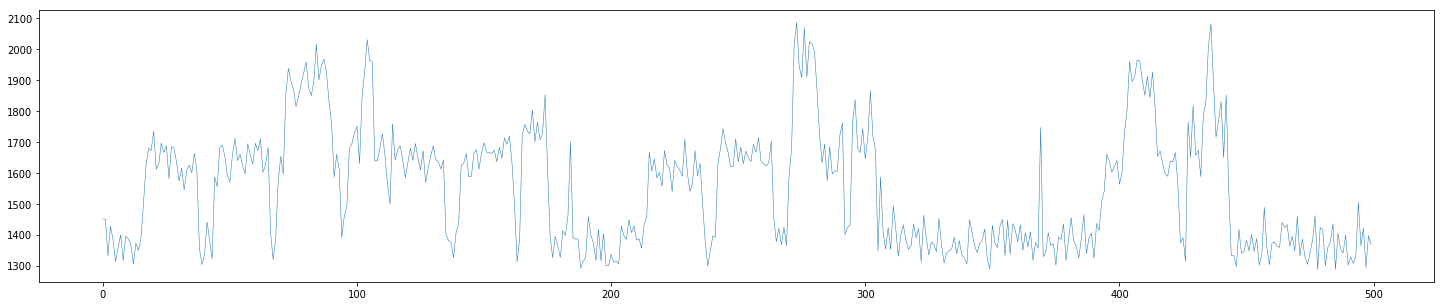

After filtering


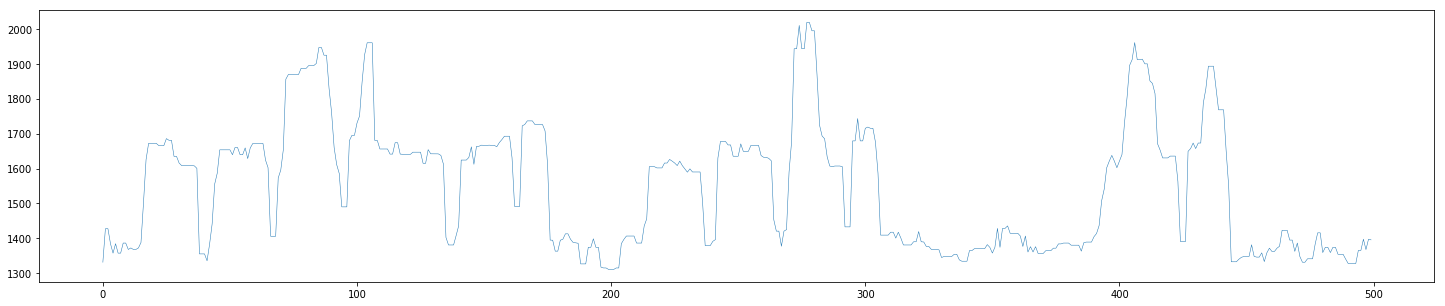

In [4]:
from scipy.signal import medfilt

print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(power["Power12"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("After filtering")
power = pandas.DataFrame({"Power12": medfilt(power["Power12"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(power["Power12"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

Combine all dataframes into a single dataset

In [5]:
all_data = pandas.concat([cpu, tx, rx, disk, power], axis=1, join="inner").drop("Time", axis=1).fillna(0)
all_data.describe()

,CPU_user,net_TX,net_RX,disk_p2,Power12
count,34560.000000,34560.000000,34560.000000,34560.000000,34560.000000
mean,396.757533,76.361343,9.475424,229.147859,1602.709057
std,337.801514,58.354279,1.213157,486.386083,189.102054
min,5.000000,12.000000,8.000000,0.000000,1300.406504
25%,13.000000,15.000000,8.000000,0.000000,1404.268293
50%,436.000000,78.000000,10.000000,0.000000,1627.642276
75%,544.166667,97.500000,10.000000,0.000000,1701.219512
max,1202.166667,251.000000,52.666667,3900.000000,2153.048780


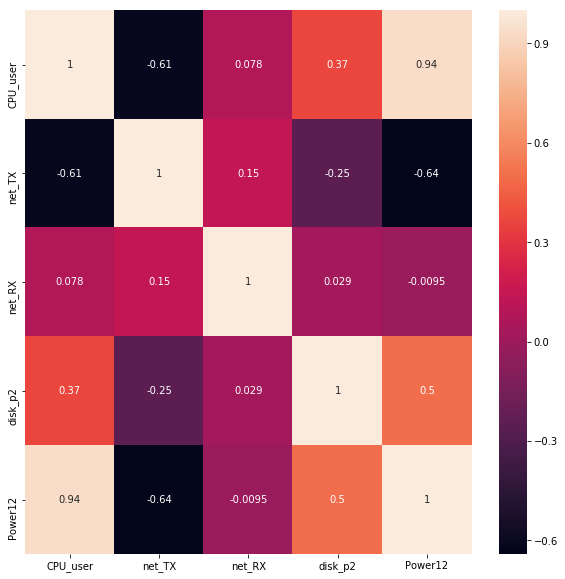

In [6]:
fig = plotter.figure(figsize=(10, 10))
seaborn.heatmap(all_data.corr(), annot=True)
plotter.show()

The heatmap shows that the ```CPU_user``` and the ```power12``` features are highly correlated. The ```net_TX``` has a negative correlation. But that is likely true only for this particular application which is running on a single Pi. 

The data will be scaled to between 0 and 1 for the input to the model.

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns = all_data.columns

all_data = pandas.DataFrame(scaler.fit_transform(all_data.as_matrix()), columns=columns)
all_data.describe()

,CPU_user,net_TX,net_RX,disk_p2,Power12
count,34560.000000,34560.000000,34560.000000,34560.000000,34560.000000
mean,0.327237,0.269294,0.033032,0.058756,0.354548
std,0.282167,0.244160,0.027160,0.124714,0.221784
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.006682,0.012552,0.000000,0.000000,0.121812
50%,0.360017,0.276151,0.044776,0.000000,0.383790
75%,0.450369,0.357741,0.044776,0.000000,0.470083
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Define dataset handlers and helpers

In [8]:
import numpy

In [9]:
class DataLoader:
    """
        Defines data loader for seq2point model.
    """
    
    def __init__(self, X, y, window=5):
        self.X = X
        self.y = y
        self.window = window
        
    def __len__(self):
        return (self.X.shape[0]-(self.window + 1))
    
    def __getitem__(self, i):
        """
            Returns single batch of data in flat seq2point compatible format.
        """
        X = self.X[i: i+self.window, :]
        # y = self.y[i+int(self.window/2)]
        y = self.y[i+self.window]
        
        return (X, y)


class BatchLoader:
    """
        Creates batches from data provided by dataloader.
    """
    
    def __init__(self, dataloader, batch_size=32):
        self.dloader = dataloader
        self.batch_size = batch_size
        self.samples = list(range(len(self.dloader)))
        
    def __len__(self):
        return int(len(self.dloader)/self.batch_size) - 1
        
    def __getitem__(self, i):
        i = i*self.batch_size
        _samples = self.samples[i: i+self.batch_size]
        
        X=[]
        y=[]
        
        for j in range(len(_samples)):
            _X, _y = self.dloader[_samples[j]]
            X.append(_X.ravel())
            y.append(_y)
        
        return numpy.array(X), numpy.array(y)
    
class ConvBatchLoader:
    """
        Creates conv batches from data provided by dataloader.
    """
    
    def __init__(self, dataloader, batch_size=32):
        self.dloader = dataloader
        self.batch_size = batch_size
        self.samples = list(range(len(self.dloader)))
        
    def __len__(self):
        return int(len(self.dloader)/self.batch_size) - 1
        
    def __getitem__(self, i):
        i = i*self.batch_size
        _samples = self.samples[i: i+self.batch_size]
        
        X=[]
        y=[]
        
        for j in range(len(_samples)):
            _X, _y = self.dloader[_samples[j]]
            X.append(_X)
            y.append(_y)
        
        return numpy.array(X), numpy.array(y)

In [10]:
class DisaggDataLoader:
    """
        Defines data loader for disaggregation model.
    """
    
    def __init__(self, X, y, window=5):
        self.X = X
        self.y = y
        self.window = window
        
    def __len__(self):
        return (self.X.shape[0]-(self.window+1))
    
    def __getitem__(self, i):
        """
            Returns single batch of data in flat seq2point compatible format.
        """
        X = self.X[i: i+self.window]
        cpu_y = self.y.iloc[i+int(self.window/2)]["CPU_user"]
        tx_y = self.y.iloc[i+int(self.window/2)]["net_TX"]
        rx_y = self.y.iloc[i+int(self.window/2)]["net_RX"]
        disk_y = self.y.iloc[i+int(self.window/2)]["disk_p2"]
        
        return (X, {"cpu": cpu_y, "tx": tx_y, "rx": rx_y, "disk": disk_y})

In [11]:
class DisaggConvBatchLoader:
    """
        Creates conv batches from data provided by dataloader.
    """
    
    def __init__(self, dataloader, batch_size=32):
        self.dloader = dataloader
        self.batch_size = batch_size
        self.samples = list(range(len(self.dloader)))
        
    def __len__(self):
        return int(len(self.dloader)/self.batch_size) - 1
        
    def __getitem__(self, i):
        i = i*self.batch_size
        _samples = self.samples[i: i+self.batch_size]
        
        X=[]
        cpu_y=[]
        rx_y=[]
        tx_y=[]
        disk_y=[]
        
        for j in range(len(_samples)):
            _X, _y = self.dloader[_samples[j]]
            X.append(_X)
            cpu_y.append(_y["cpu"])
            rx_y.append(_y["rx"])
            tx_y.append(_y["tx"])
            disk_y.append(_y["disk"])
        
        return numpy.array(X), {"cpu": numpy.array(cpu_y), "tx": numpy.array(tx_y), "rx": numpy.array(rx_y), "disk": numpy.array(disk_y)}

The anomaly detection will be done using a thresholding function.

In [12]:
def run_thresholding(data):
        arr = pandas.Series(data)
        mean = 0
        count = 0
        outliers = numpy.zeros_like(arr)
        thres = numpy.zeros_like(arr)
        means = numpy.zeros_like(arr)
        cmeans = arr.expanding().mean()
        std = 0

        # Compute running stats

        m2 = 0
        for i in range(len(arr)):

            if i > 100 and arr[i] > (mean + 4.0 * std):
                outliers[i] = data[i]
                means[i] = mean
                thres[i] = mean + (4.0 * std)
                continue

            count = count + 1
            delta = arr[i] - mean

            mean = mean + (delta/count)
            means[i] = mean

            new_delta = arr[i] - mean
            m2 = m2 + delta * new_delta

            std = numpy.sqrt(m2 / count)

            thres[i] = mean + (4.0 * std)
            
        return thres, outliers

Define generator for keras models

In [13]:
def data_gen(loader):
    while 1:
        for i in range(len(loader)):
            yield loader[i]

Split the dataset into training, validation and testing set.

In [14]:
training_set = all_data[:25000]
validation_set = all_data[25000:30000]
testing_set = all_data[30000:]

### Aggregation Model

In [15]:
from keras.layers import Conv1D, Input, Dense, Flatten, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import mean_absolute_error

/home/adityas/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Prepare training and validation datasets for the aggregation model

Training Set

In [16]:
agg_train_y = training_set["Power12"]
agg_train_X = training_set.drop("Power12", axis=1)
agg_train_loader = ConvBatchLoader(dataloader=DataLoader(X=agg_train_X.as_matrix(), y=agg_train_y.as_matrix(), window=51), batch_size=64)
agg_train_generator = data_gen(agg_train_loader)

Validation Set

In [17]:
agg_val_y = validation_set["Power12"]
agg_val_X = validation_set.drop("Power12", axis=1)
agg_val_loader = ConvBatchLoader(dataloader=DataLoader(X=agg_val_X.as_matrix(), y=agg_val_y.as_matrix(), window=51), batch_size=5000)
agg_val_X, agg_val_y = agg_val_loader[0]

Define Aggregation model

In [18]:
agg_input = Input(shape=(51, 4))
agg_conv = Conv1D(kernel_size=10, filters=20, activation="relu")(agg_input)
agg_conv = Conv1D(kernel_size=10, filters=10, activation="relu")(agg_conv)
agg_conv = MaxPooling1D(pool_size=2)(agg_conv)
agg_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(agg_conv)
agg_conv = MaxPooling1D(pool_size=2)(agg_conv)
agg_conv = Conv1D(kernel_size=5, filters=10, activation="sigmoid")(agg_conv)
agg_flat = Flatten()(agg_conv)
agg_out = Dense(1, activation="sigmoid")(agg_flat)

In [19]:
agg_model = Model(inputs=agg_input, outputs=agg_out)
agg_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])

Display aggregation model

In [20]:
plot_model(agg_model, to_file="agg_model.png", show_shapes=True)

<img src="agg_model.png">

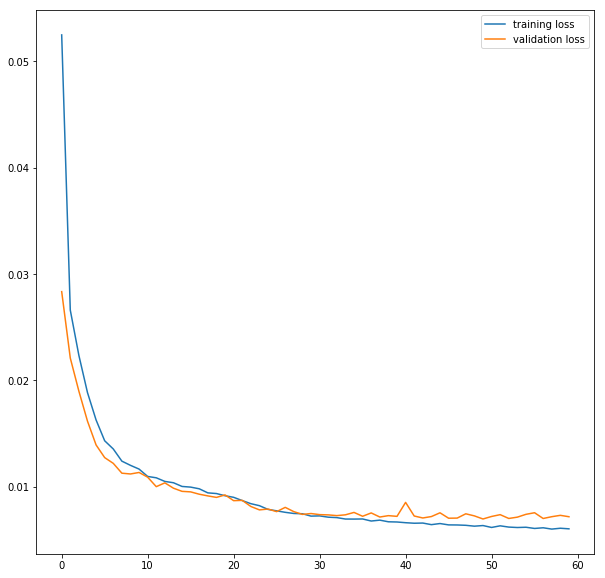

In [21]:
estopper = EarlyStopping(monitor="val_loss", patience=10)
loss = agg_model.fit_generator(callbacks=[estopper], 
                               generator=agg_train_generator, 
                               validation_data=(agg_val_X, agg_val_y), 
                               shuffle=True, 
                               steps_per_epoch=500, 
                               epochs=100,
                               verbose=0)

fig = plotter.figure(figsize=(10, 10))
plotter.plot(loss.history["loss"], label="training loss")
plotter.plot(loss.history["val_loss"], label="validation loss")
plotter.legend()
plotter.show()

In [22]:
agg_model.evaluate(x=agg_val_X, y=agg_val_y, verbose=1)

4948/4948 [==============================] - 0s 38us/step


[0.007182961231565876, 0.05701279270077966]

### Disaggregation model

Prepare training and validation sets for disaggregation model

Training set

In [23]:
disagg_train_X = training_set["Power12"]
disagg_train_y = training_set.drop("Power12", axis=1)
disagg_train_loader = DisaggConvBatchLoader(dataloader=DisaggDataLoader(X=disagg_train_X.as_matrix()[:, numpy.newaxis], 
                                                                        y=disagg_train_y, 
                                                                        window=51), 
                                            batch_size=64)

disagg_train_generator = data_gen(disagg_train_loader)

Validation set

In [24]:
disagg_val_X = validation_set["Power12"]
disagg_val_y = validation_set.drop("Power12", axis=1)
disagg_val_loader = DisaggConvBatchLoader(dataloader=DisaggDataLoader(X=disagg_val_X.as_matrix()[:, numpy.newaxis],
                                                                      y=disagg_val_y, 
                                                                      window=51), 
                                          batch_size=5000)

disagg_val_X, disagg_val_y = disagg_val_loader[0]

Define disaggregation model

In [25]:
disagg_input = Input(shape=(51, 1))
disaggconv = Conv1D(kernel_size=10, filters=40, activation="relu")(disagg_input)
disaggconv = MaxPooling1D(pool_size=2)(disaggconv)
disaggconv = Conv1D(kernel_size=10, filters=40, activation="relu")(disaggconv)

#CPU
disagg_cpu_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disaggconv)
disagg_cpu_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disagg_cpu_conv)
disagg_cpu_flat = Flatten()(disagg_cpu_conv)
disagg_cpu_out = Dense(1, activation="sigmoid", name="cpu")(disagg_cpu_flat)

#TX
disagg_tx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disaggconv)
disagg_tx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disagg_tx_conv)
disagg_tx_flat = Flatten()(disagg_tx_conv)
disagg_tx_out = Dense(1, activation="sigmoid", name="tx")(disagg_tx_flat)

#RX
disagg_rx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disaggconv)
disagg_rx_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disagg_rx_conv)
disagg_rx_flat = Flatten()(disagg_rx_conv)
disagg_rx_out = Dense(1, activation="sigmoid", name="rx")(disagg_rx_flat)

#Disk
disagg_disk_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disaggconv)
disagg_disk_conv = Conv1D(kernel_size=5, filters=10, activation="relu")(disagg_disk_conv)
disagg_disk_flat = Flatten()(disagg_disk_conv)
disagg_disk_out = Dense(1, activation="sigmoid", name="disk")(disagg_disk_flat)

In [26]:
disagg_model = Model(inputs=disagg_input, outputs=[disagg_cpu_out, 
                                                   disagg_tx_out, 
                                                   disagg_rx_out, 
                                                   disagg_disk_out])
disagg_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])

Display model

In [27]:
plot_model(disagg_model, to_file="disagg_model.png", show_shapes=True)

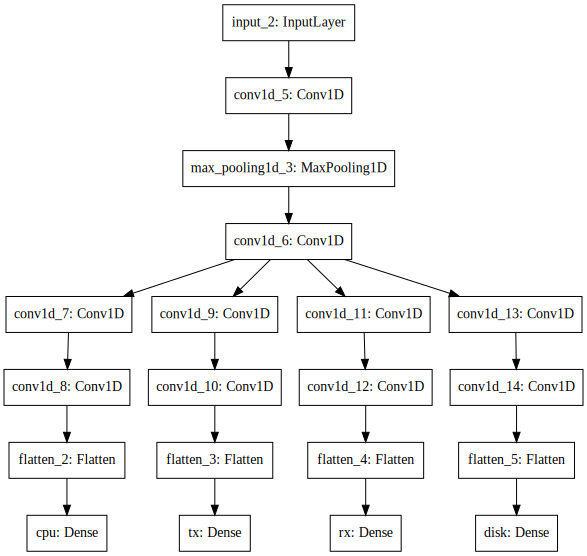

In [28]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(disagg_model).create(prog='dot', format='svg'))

Train model

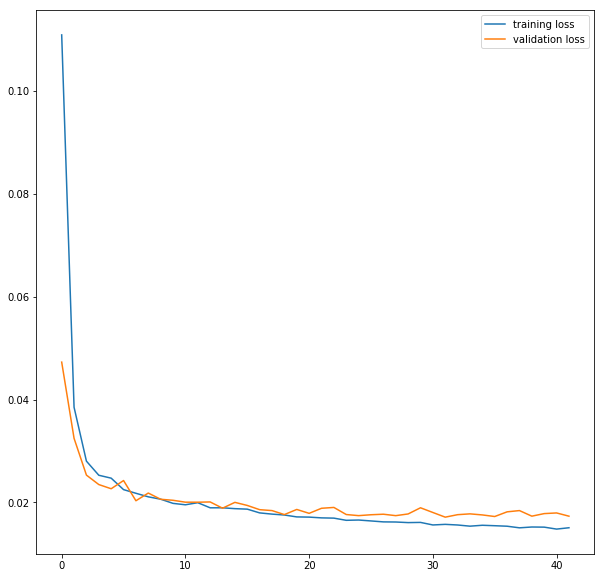

In [29]:
estopper = EarlyStopping(monitor="val_loss", patience=10)
loss = disagg_model.fit_generator(callbacks=[estopper], 
                                  generator=disagg_train_generator, 
                                  validation_data=(disagg_val_X, disagg_val_y), 
                                  shuffle=True, 
                                  steps_per_epoch=500, 
                                  epochs=100,
                                  verbose=0)

fig = plotter.figure(figsize=(10, 10))
plotter.plot(loss.history["loss"], label="training loss")
plotter.plot(loss.history["val_loss"], label="validation loss")
plotter.legend()
plotter.show()

In [30]:
disagg_model.evaluate(x=disagg_val_X, y=disagg_val_y, verbose=1)

4948/4948 [==============================] - 0s 80us/step


[0.017328684387627684,
 0.0035255659978683422,
 0.011697326219844328,
 0.000677200349344418,
 0.001428591848583646,
 0.038112276454328915,
 0.0675874530437885,
 0.01899720928665603,
 0.012946310844022216]

------

# System operation

Define the prediction system consisting of the trained aggregation and disaggregation models

In [31]:
def make_prediction(power_X):
    
    cpu_pred = []
    tx_pred = []
    rx_pred = []
    disk_pred = []
    
    for i in range(power_X.shape[0] - 51):
        _inp = power_X[i:i+51][numpy.newaxis,:, numpy.newaxis]
    
        # Disaggregation part
        disagg_predictions = disagg_model.predict(_inp)
    
        cpu_pred.append(disagg_predictions[0].ravel())
        tx_pred.append(disagg_predictions[1].ravel())
        rx_pred.append(disagg_predictions[2].ravel())
        disk_pred.append(disagg_predictions[3].ravel())
    
    data = numpy.vstack([numpy.array(cpu_pred).ravel(),
                         numpy.array(tx_pred).ravel(),
                         numpy.array(rx_pred).ravel(),
                         numpy.array(disk_pred).ravel()])
    
    data = data.T
    
    power_pred = []
    for j in range(data.shape[0] - 51):
        _inp = data[j:j+51][numpy.newaxis,:,:]

        # Aggregation model
        power_pred.append(agg_model.predict(_inp))
    
    return numpy.array(power_pred).ravel()

Test on normal behavior

In [32]:
test_norm_X = testing_set["Power12"].as_matrix().ravel()

Make power prediction after disaggregation

In [33]:
power_prediction = make_prediction(test_norm_X)

Test plots and differences in prediction of normal data

Normal Behavior


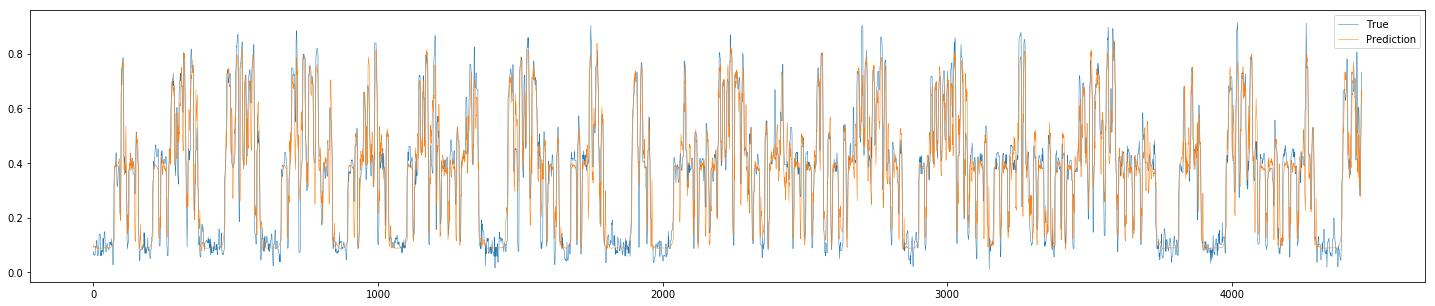

Finer look at first 1000 predictions


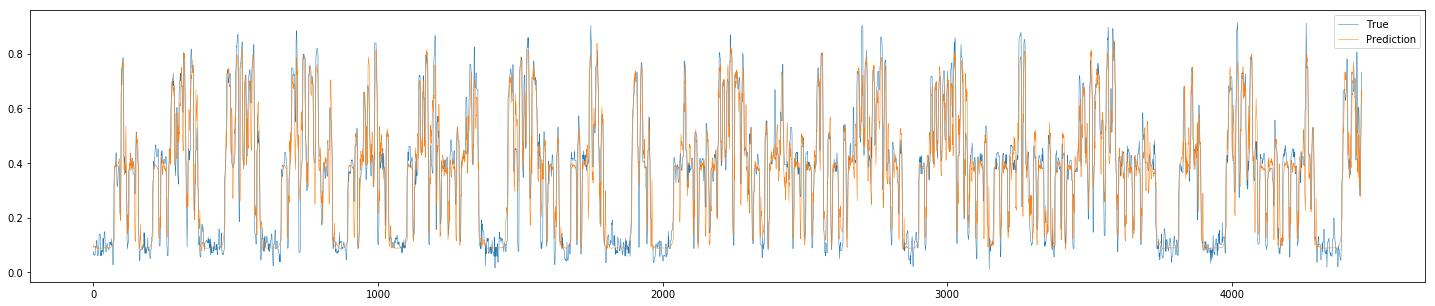

difference


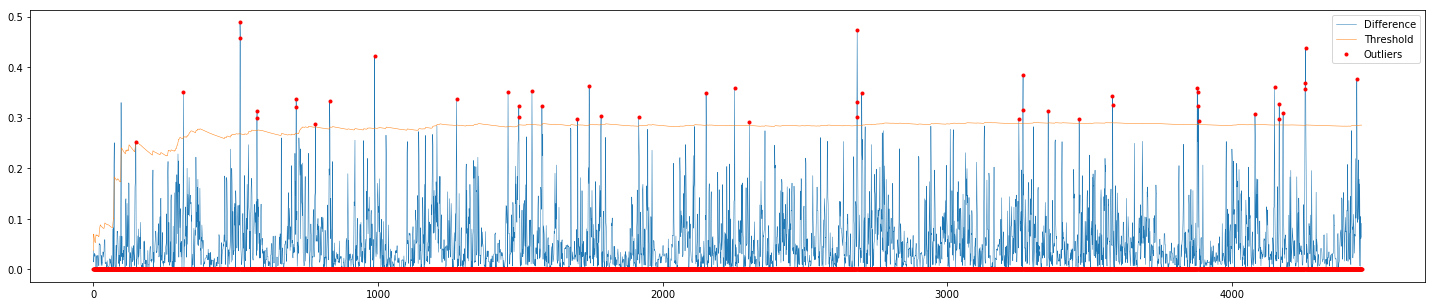

difference


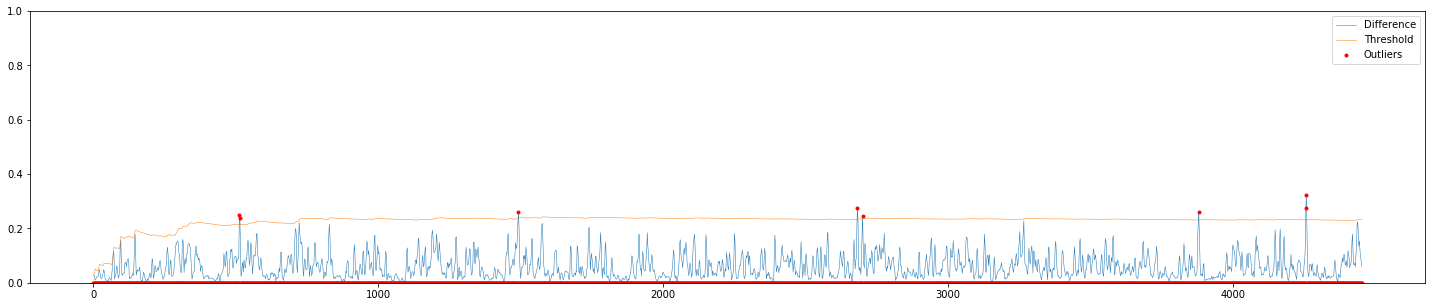

In [34]:
power_input = test_norm_X[76:-26]
print("Normal Behavior")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input, linewidth=0.5, label="True")
plotter.plot(power_prediction, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("Finer look at first 1000 predictions")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input, linewidth=0.5, label="True")
plotter.plot(power_prediction, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
diff = numpy.abs(power_input - power_prediction)
thres, outliers = run_thresholding(diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
window = 5
diff = numpy.abs(power_input - power_prediction)

error = []
indexes = []
for i in range(0, diff.shape[0]-window, int(window/2.0)):
    error.append(diff[i: i+window])
    indexes.append(i)
    
error = numpy.mean(numpy.array(error), axis=1)
indexes = numpy.array(indexes).ravel()
diff = diff[indexes]
thres, outliers = run_thresholding(error.ravel())
fig = plotter.figure(figsize=(25,5))
plotter.plot(indexes,error, linewidth=0.5, label="Difference")
plotter.plot(indexes, thres, linewidth=0.5, label="Threshold")
plotter.plot(indexes, outliers, 'r.', linewidth=0.5, label="Outliers")
plotter.ylim(0,1)
plotter.legend()
plotter.show()

Test on synthetic abnormal behavior

In [35]:
test_norm_X.shape

(4560,)

In [36]:
test_norm_X = testing_set["Power12"].as_matrix().ravel()
test_norm_X[3000:3050] += 0.5

Make power prediction after disaggregation

In [37]:
power_prediction = make_prediction(test_norm_X)

Test plots and differences in prediction of normal data

Normal Behavior


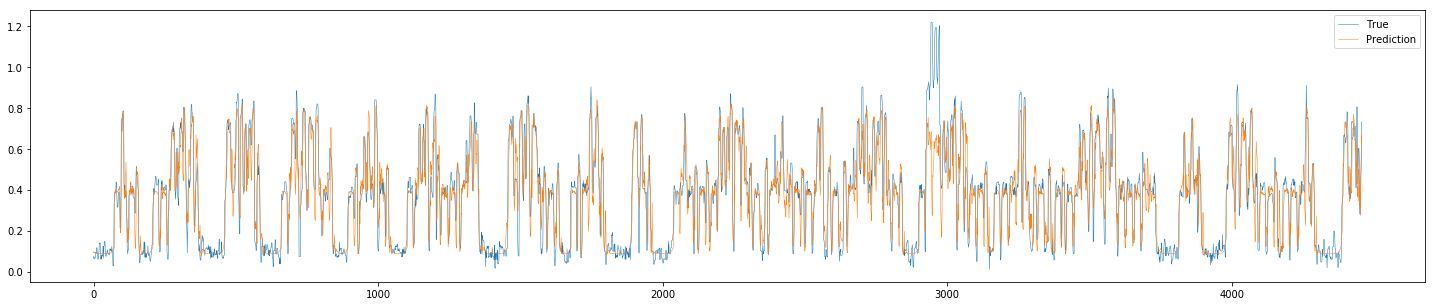

Finer look at first 1000 predictions


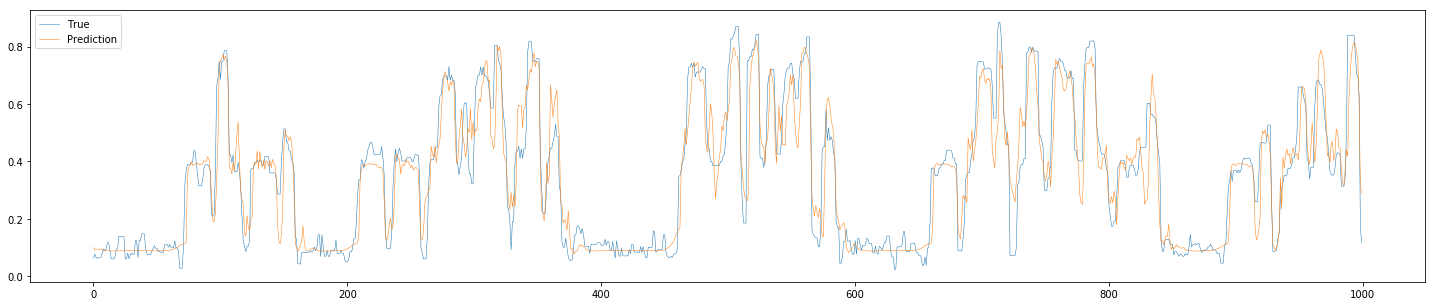

difference


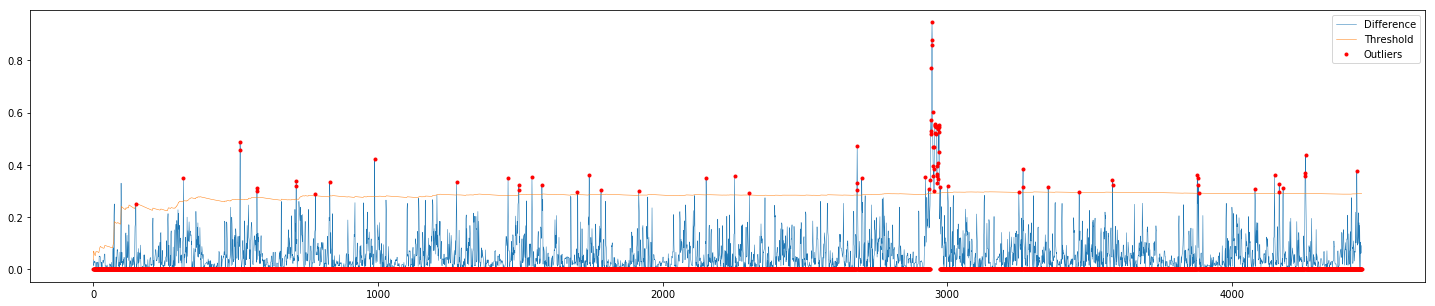

difference


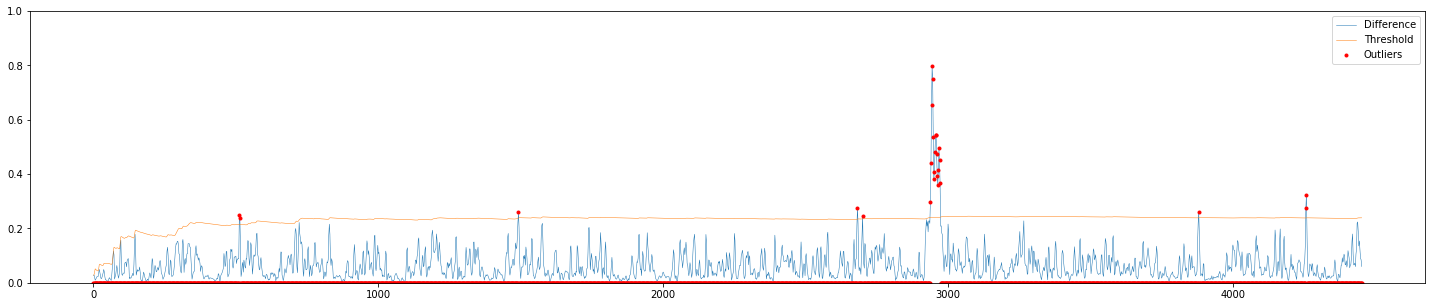

In [38]:
power_input = test_norm_X[76:-26]
print("Normal Behavior")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input, linewidth=0.5, label="True")
plotter.plot(power_prediction, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("Finer look at first 1000 predictions")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input[:1000], linewidth=0.5, label="True")
plotter.plot(power_prediction[:1000], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
diff = numpy.abs(power_input - power_prediction)
thres, outliers = run_thresholding(diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
window = 5
diff = numpy.abs(power_input - power_prediction)

error = []
indexes = []
for i in range(0, diff.shape[0]-window, int(window/2.0)):
    error.append(diff[i: i+window])
    indexes.append(i)
    
error = numpy.mean(numpy.array(error), axis=1)
indexes = numpy.array(indexes).ravel()
diff = diff[indexes]
thres, outliers = run_thresholding(error.ravel())
fig = plotter.figure(figsize=(25,5))
plotter.plot(indexes,error, linewidth=0.5, label="Difference")
plotter.plot(indexes, thres, linewidth=0.5, label="Threshold")
plotter.plot(indexes, outliers, 'r.', linewidth=0.5, label="Outliers")
plotter.ylim(0,1)
plotter.legend()
plotter.show()

Testing for abnormal data

Load anomalous data

In [39]:
data = Path("../data/summer_proc_test/")
files = list(data.iterdir())

In [40]:
disk = pandas.read_csv(str(data/"summer_proc_test_disk.csv")).drop("Unnamed: 0", axis=1)
cpu = pandas.read_csv(str(data/"summer_proc_test_cpu.csv")).drop("Unnamed: 0", axis=1)
power = pandas.read_csv(str(data/"summer_proc_test_power.csv")).drop("Unnamed: 0", axis=1).fillna(0)
tx = pandas.read_csv(str(data/"summer_proc_test_tx.csv")).drop("Unnamed: 0", axis=1)
rx = pandas.read_csv(str(data/"summer_proc_test_rx.csv")).drop("Unnamed: 0", axis=1)

Preprocessing the power signal again

Before filtering


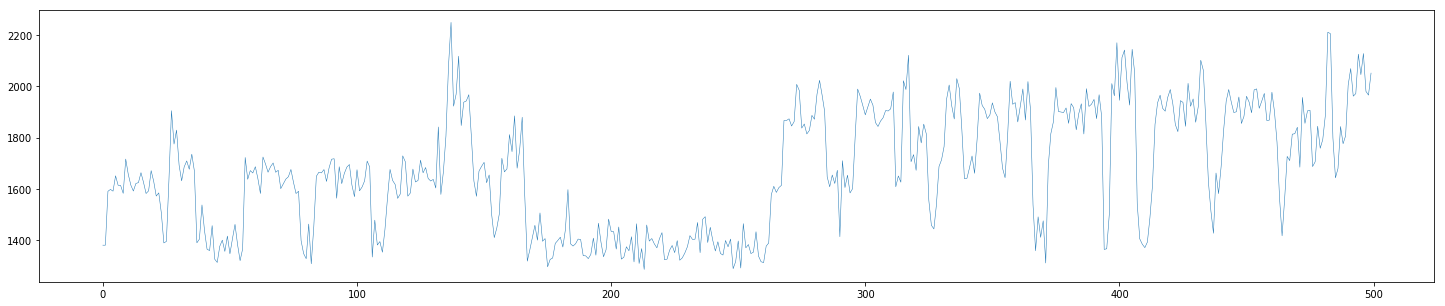

After filtering


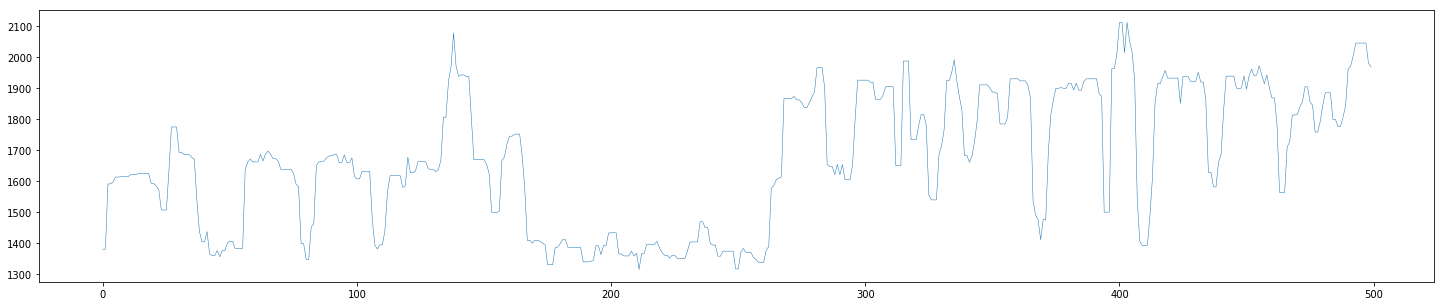

In [41]:
from scipy.signal import medfilt

print("Before filtering")
fig = plotter.figure(figsize=(25, 5))
plotter.plot(power["Power12"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

print("After filtering")
power = pandas.DataFrame({"Power12": medfilt(power["Power12"].as_matrix().ravel(), kernel_size=5)})
fig = plotter.figure(figsize=(25, 5))
plotter.plot(power["Power12"].as_matrix().ravel()[0: 500], linewidth=0.5, label="Before filtering")
plotter.show()

In [42]:
test_data = pandas.concat([cpu, tx, rx, disk, power], axis=1, join="inner").drop("Time", axis=1).fillna(0)

In [43]:
columns = test_data.columns

test_data = pandas.DataFrame(scaler.transform(test_data.as_matrix()), columns=columns)

In [44]:
test_data.describe()

,CPU_user,net_TX,net_RX,disk_p2,Power12
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,0.416236,1.056093,4.558893,0.057001,0.587766
std,0.333748,2.509155,13.571451,0.124311,0.382047
min,0.000835,0.000000,0.000000,0.000000,0.018117
25%,0.007239,0.012552,0.000000,0.000000,0.238379
50%,0.434150,0.033473,0.044776,0.000000,0.564482
75%,0.730788,0.552301,0.055970,0.000855,0.803874
max,0.936795,11.148536,59.652985,0.873077,1.547080


Create anomalous test set

In [45]:
test_abnorm_X = test_data["Power12"].as_matrix().ravel()

In [46]:
power_prediction = make_prediction(test_abnorm_X)

Normal Behavior


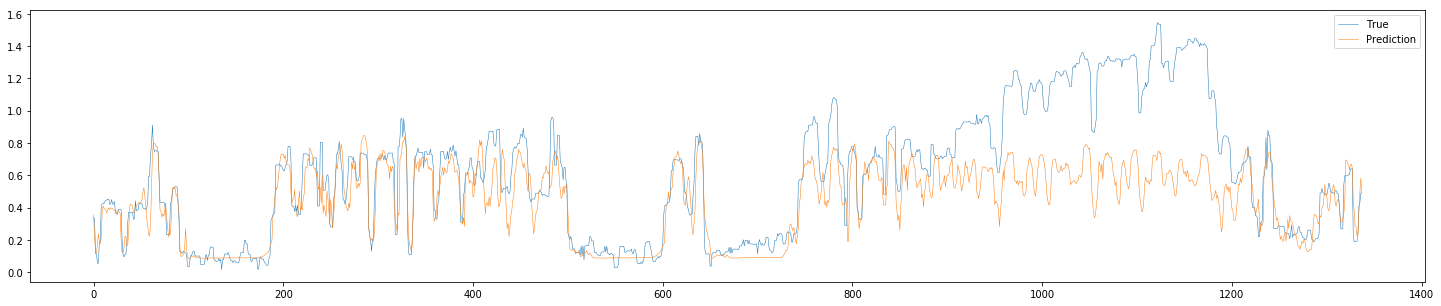

Finer look at first 1000 predictions


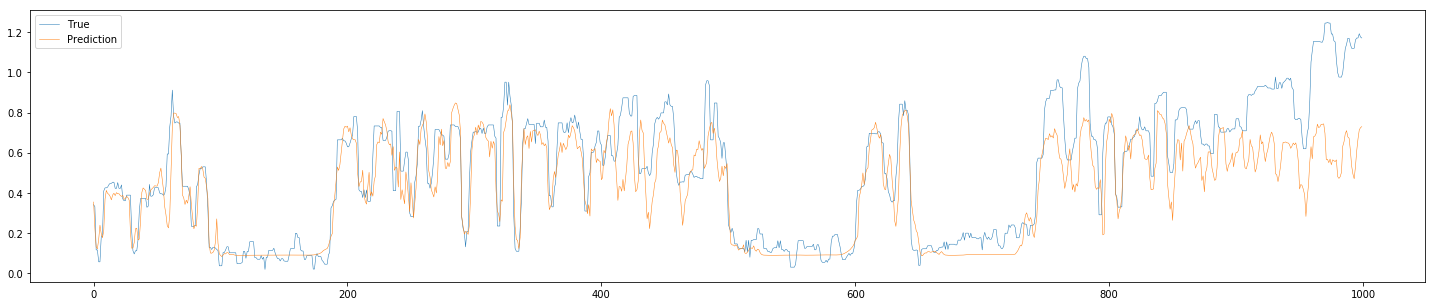

Finer look at last 1000 predictions


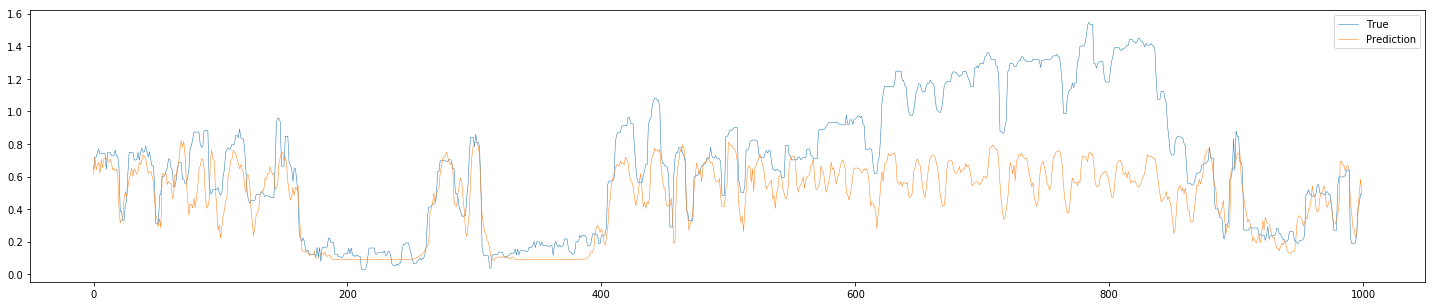

RX


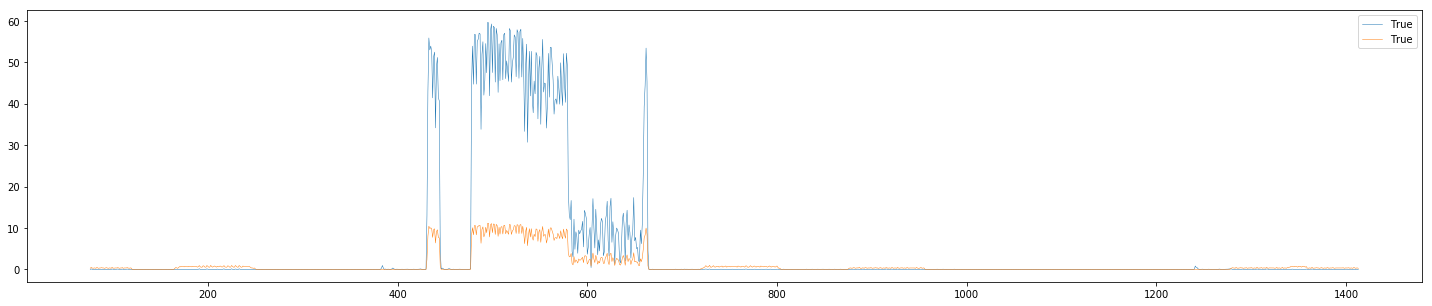

difference


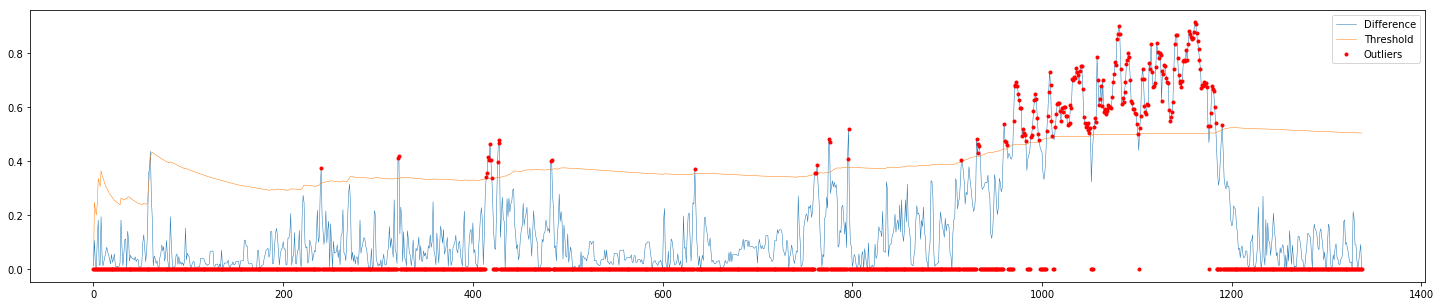

difference


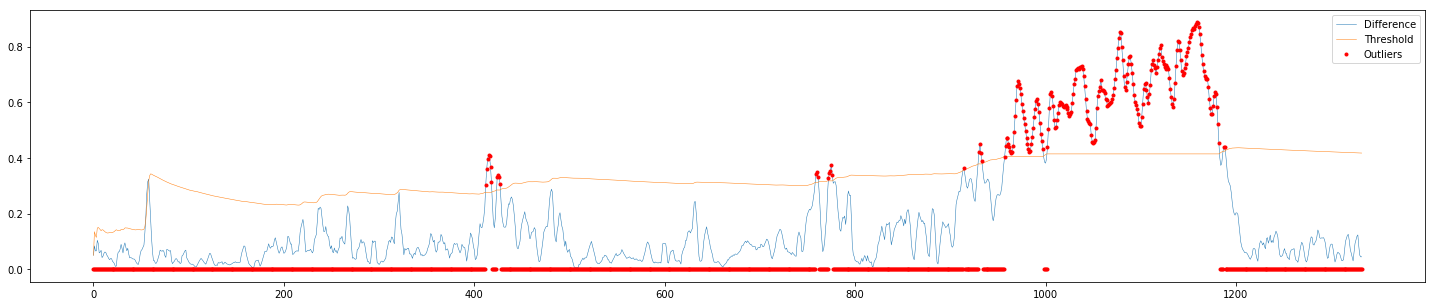

In [51]:
power_input = test_abnorm_X[76:-26]
print("Normal Behavior")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input, linewidth=0.5, label="True")
plotter.plot(power_prediction, linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("Finer look at first 1000 predictions")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input[:1000], linewidth=0.5, label="True")
plotter.plot(power_prediction[:1000], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("Finer look at last 1000 predictions")
fig = plotter.figure(figsize=(25,5))
plotter.plot(power_input[-1000:], linewidth=0.5, label="True")
plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("RX")
fig = plotter.figure(figsize=(25,5))
plotter.plot(test_data["net_RX"][76:-26], linewidth=0.5, label="True")
plotter.plot(test_data["net_TX"][76:-26], linewidth=0.5, label="True")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
diff = numpy.abs(power_input - power_prediction)
thres, outliers = run_thresholding(diff)
fig = plotter.figure(figsize=(25,5))
plotter.plot(diff, linewidth=0.5, label="Difference")
plotter.plot(thres, linewidth=0.5, label="Threshold")
plotter.plot(outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()

print("difference")
window = 5
diff = numpy.abs(power_input - power_prediction)

error = []
indexes = []
for i in range(0, diff.shape[0]-window):
    error.append(diff[i: i+window])
    indexes.append(i)
    
error = numpy.mean(numpy.array(error), axis=1)
indexes = numpy.array(indexes).ravel()
diff = diff[indexes]
thres, outliers = run_thresholding(error.ravel())
fig = plotter.figure(figsize=(25,5))
plotter.plot(indexes,error, linewidth=0.5, label="Difference")
plotter.plot(indexes, thres, linewidth=0.5, label="Threshold")
plotter.plot(indexes, outliers, 'r.', linewidth=0.5, label="Outliers")
#plotter.plot(power_prediction[-1000:], linewidth=0.5, label="Prediction")
plotter.legend()
plotter.show()